## Multi-Layer Networks

Now that we have tried our hand at some single-layer nets, let's see how they _stack up_ compared to multi-layer nets. 😁

We will be exploring the basic concepts of learning non-linear functions using the classic XOR problem, and then explore the basics of "deep learning" technology on this problem as well. After that, we will see if a multi-layer approach can perform better than single-layer approach on some data sets that we have seen before. In particular, we will try to explore the wider vs. deeper issue, and see if ReLU really helps.

For now, let's look into the XOR problem, and see what insights we can gain when comparing single- and multi-layer network approaches.

In [1]:
# NN-Tools
import numpy as np
import tensorflow.keras as keras

# Visualization
from IPython.display import SVG
from IPython.display import display
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

# Printing
from sympy import *
init_printing(use_latex=True)

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline

Let's create the XOR data set. As we mentioned in class, _avoiding zeros_ in the **input** patterns is a good general approach for stable learning behavior.

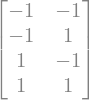

In [2]:
# XOR data set
X = np.array([[-1,-1],[-1,1],[1,-1],[1,1]])
display(Matrix(X))
Y = np.array([0,1,1,0])
display(Matrix(Y))

We are performing a classification task since there are **two discrete targets**, so using **binary cross-entropy** error at the output layer makes sense. Also, binary cross-entropy suggest the **sigmoid** activation function for the **output** unit since it is comparing only two classes. Given that the hyperbolic tangent (tanh) activation function is a decent choice for two-layer networks, let's create a network with a hidden layer consisting of units which use this activation function. Also, we will keep it rather small: just two units.

In [3]:
# Multi-layer net with tanh hidden layer

# Start a new, empty model
model = keras.models.Sequential()

# Create the hidden layer (size 2), but also ensure it is
# densely connected to an input layer of size 2 (input_dim=2).
# These are then added to the model...
model.add(keras.layers.Dense(2,input_dim=2,activation='tanh'))

# Add another densely connected layer, our output layer,
# which is assumed to be connected to the -previous layer-
# added to the model (the hidden layer in our case).
model.add(keras.layers.Dense(1,activation='sigmoid'))

# Compile it and use the correct loss function (BCE) and
# a good optimizer (to avoid slow convergence when possible).
model.compile(loss=keras.losses.BinaryCrossentropy(),
              optimizer=keras.optimizers.SGD(lr=0.1),
              metrics=[keras.metrics.BinaryAccuracy()])

# Print the resulting model to observe its structure and
# number of parameters.
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2)                 6         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3         
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________


Since the input vectors are of length 2, and the hidden layer is of size 2, there will be a 2x2=4 element weight matrix connecting the input layer to the hidden layer. Also, each hidden unit will have a bias weight (6 weights total so far). The hidden to output layer weight matrix will be 2x1=2, and the output unit has its own bias weight as well (total of 9, altogether).

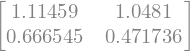

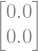

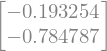

In [4]:
# Print the weights!
for i in model.get_weights():
    display(Matrix(i))

You can see that for tanh units, the bias weight is initialized to zero. We know that zero-element weights can be problematic in some cases, but remember that the bias is **always** used and therefore has access to the full delta for the units. They will only differentiate when required by the task at-hand.

If we want a graph-like representation of our network, we can use some functions from `keras.utils` such as `plot_model()` to make an image file with a visualization and then also utilize `IPython.display` to render such a representation:

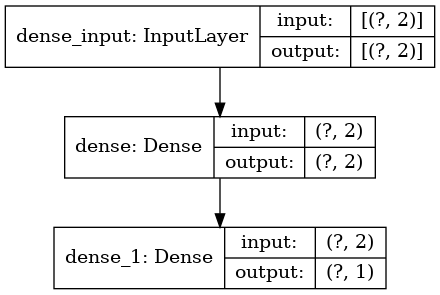

In [5]:
plot_model(model,to_file='xor_tanh.png',show_shapes=True,expand_nested=True)

Not so interesting really for this simple network, but this will be even more informative for more complex models that we make later in the semester. In particular, note that the input and output *shapes* that the layers expect is presented as part of the representation. These shapes are important because data fed into the network must have a corresponding shape in order to be compatible with the network. The (?,2) shape indicates that the input layer can accept an $Nx2$ size data matrix. The value $N$ is set at training/testing time based on the data matrix provided for training/testing. Our current matrix of interest with the four input patterns, $X$, is of shape $4x2$, which will work nicely with this net.

## Backprop Using Numpy/Sympy

Just like the single-layer case, it's good to see how the math from the lecture describing the backpropagation learning algorithm might be implemented more directly. Of course, numpy/sympy will be used to simplify the code considerably in many ways, but we are still able to show how Keras/Tensorflow is really computing the exact same equations that we have already seen.

As a start, let's store and then examine those weights one more time:

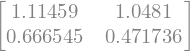

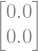

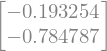

In [6]:
## The weight matrices
weights = model.get_weights()

# Break down into each component of the network
input_to_hidden = weights[0]
hidden_bias = weights[1]
hidden_to_output = weights[2]
output_bias = weights[3]

display(Matrix(input_to_hidden))
display(Matrix(hidden_bias))
display(Matrix(hidden_to_output))
display(Matrix(output_bias))

Now that we have separated the different weight matrices into components, let's see if we can match a forward pass calculation. I will start with the numpy version, and then compare with the keras/tensorflow result from `predict()` to show how the forward pass can be emulated. Then we will proceed with the backward pass through the network to update the weights.

Still, before we can actually perform backprop, we will need to create some functions that we will use to mimic Keras. In particular, we need the `tanh()` and `sigmoid()` activation functions and their first derivatives. The activation functions can be used to calculate neural activation values for the forward pass and their derivatives will be used to calculate the neural deltas for the backward pass.

In addition to the activation functions, we need to calculate the error (in this case, **binary cross entropy**) function and also the first derivative of the error function (with respect to neural activations) for the backward pass in order to calculate the weight updates.

In [7]:
# Use sympy for differentiation of our activation
# functions and error function
x = symbols('x')
y = symbols('y')

# Tanh Activation Function - Vectorized g(x)
g = (exp(2*x)-1)/(exp(2*x)+1)
tanh = np.vectorize(lambda x: np.float32(g.evalf(subs=dict(x=x))))

# First Derivative of Tanh - Vectorized dg(x)/dx
dgdx = g.diff(x)
dtanh = np.vectorize(lambda x: np.float32(dgdx.evalf(subs=dict(x=x))))

# Sigmoid Activation Function - Vectorized f(x)
f = 1 / (exp(-x)+1)
sigmoid = np.vectorize(lambda x: np.float32(f.evalf(subs=dict(x=x))))

# First Derivative of Tanh - Vectorized dg(x)/dx
dfdx = f.diff(x)
dsigmoid = np.vectorize(lambda x: np.float32(dfdx.evalf(subs=dict(x=x))))

# Binary Cross-entropy Error (and first derivative)
b = -((y*log(x)+(1-y)*log(1-x)))
dbdx = b.diff(x)

# Vectorized forms of BCE and dBCE(x)/x
bce = np.vectorize(lambda y,x: np.float32(b.evalf(subs=dict(x=x,y=y))))
dbce = np.vectorize(lambda y,x: np.float32(dbdx.evalf(subs=dict(x=x,y=y))))

Each of the calls to `vectorize()` above is creating a function that can be applied directly to numpy arrays. This means we can for example use `tanh()` to now calculate the hyperbolic tangent activation function element-wise for all entries in an N-dimensional array instead of having to write code to loop over elements in the array ourselves. We can accomplish a similar effort for it's first derivative using the `dtanh()` function that we have created. I facilitated this above by just using sympy to create the mathematical expressions for the functions and then use `vectorize()` to allow numpy to numerically evaluate those expressions (and their derivatives) across all of the values in a numpy array.

We are now ready to proceed with demonstrating how the backprop algorithm works using these mathematical tools. Let's start with comparing the forward pass using numpy with the forward pass from Keras.

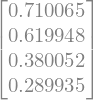

In [8]:
# Initialize the starting point in the calculations to be
# the four training patterns that we would like to pass
# through the network. Then pass the output of each step
# in the network calculation through.

# Input layer just takes a copy of the patterns
input_a = X

# Hidden layer net inputs (weighted sums)
hidden_net = np.dot(input_a,input_to_hidden) + hidden_bias

# Apply the hyperbolic tangent activation function
hidden_a = tanh(hidden_net)

# Output layer net inputs (weighted sums)
output_net = np.dot(hidden_a,hidden_to_output) + output_bias

# Apply the sigmoid activation function
output_a = sigmoid(output_net)

# Some parameters we will need later
N = np.float32(output_a.shape[0]) # 4 patterns
eta = 0.1                         # learning rate (matches keras model above)

# Print the outputs of the network for each of the patterns
Matrix(output_a)

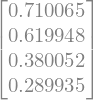

In [9]:
# Keras
Matrix(model.predict(X))

An exact match, yes? This means that we now can start to understand how to code a forward pass through the network using direct computation and how keras provides those tools for us automatically (far less coding).

Now that we have calculated the outputs, we can see that they are not what they **should** be. We need to calculate the amount of error or loss in our current computation. We will use both the numpy/sympy version and compare that to the keras version (both using BCE).

In [10]:
error = bce(np.expand_dims(Y,1),output_a).T
Matrix(error)

In [11]:
# Check against Keras/Tensorflow calculations
Matrix(keras.losses.binary_crossentropy(np.expand_dims(Y,1),output_a).numpy()).T

OK, so we have a match on our error function. That is, both our numpy/sympy tools and our keras/tensorflow tools are calculating the same error/loss values (you might see a very slight numerical difference but it should still be the same within five decimal places). Let's proceed then with the first step of error backpropagation: calculating the **delta** terms for the output layer.

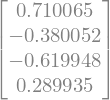

In [12]:
output_deltas = dbce(np.expand_dims(Y,1),output_a)*dsigmoid(output_net)
Matrix(output_deltas)

The delta term is just the derivative of the error function with respect to the unit activations times the derivative of the activation function with respect to the unit net inputs, just as described in the lecture slides.

Note that there are 4 delta terms because there were 4 input patterns. In the end, we will average these together since we are interested in minimizing the expected loss across all patterns. Still, once we have the deltas we can use them to calculate the updates for the weights from the hidden layer to the output layer and also the bias weights on the output layer units.

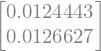

In [13]:
hidden_to_output_updates = -eta*np.dot(hidden_a.T,output_deltas)/N
Matrix(hidden_to_output_updates)

In [14]:
output_bias_updates = -eta*np.sum(output_deltas,0)/N
Matrix(output_bias_updates)

Looking at the above two calculations, we can see that we are using the hidden layer activations (hidden_a) and the output layer deltas (output_deltas) to calculate the weights changes for the weights going from the hidden layer to the output layer (there are just 2 of them and so we have 2 corresponding updates). We also have an update for the output unit's single bias weight. The bias weight can be thought of as connecting to an upstream unit that is always producing a value of 1, therefore you apply the average output delta to this weight in full. This is essentially the delta rule just like we saw two labs prior.

Let's then proceed to the really important part of backpropagation, where the hidden layer deltas are calculated:

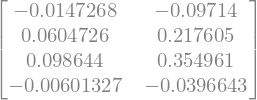

In [15]:
hidden_deltas = np.outer(output_deltas,hidden_to_output.T)*dtanh(hidden_net)
Matrix(hidden_deltas)

There are 2 hidden units in the network, but a delta is calculated for each pattern resulting in a $4x2$ matrix of delta values. These are calculated using the weighted sums of the output deltas passed *backward* along the connection weights (from the output units to the hidden units). We finally also fold in the derivative of the activation function as well, just as we did for the output units. However, we use the hyperbolic tangent's first derivative since that's the activation function we chose for these units.

Using the hidden layer deltas in combination with the input layer activations, we can calculate updates for the weights going from the input layer to the hidden layer.

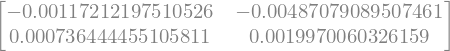

In [16]:
input_to_hidden_updates = -eta*np.dot(input_a.T,hidden_deltas)/N
Matrix(input_to_hidden_updates)

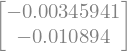

In [17]:
hidden_bias_updates = -eta*np.mean(hidden_deltas,0)
Matrix(hidden_bias_updates)

OK, at this point, we now have a complete backward pass, and all of the corresponding weight updates for each weight in the network. We just need to apply those updates to the current weights in order to learn (just add them to the current weights). However, we will also need to verify that keras does the same thing for us for one epoch of training since this is what we have performed just now with numpy/sympy.

Let's first calculate the updates with keras, and compare our loss calculations with those reported by keras during the learning phase using `fit()`:

In [18]:
history = model.fit(X,Y,epochs=1,verbose=0,shuffle=False)
history.history['loss']

In [19]:
Matrix([np.sum(bce(np.expand_dims(Y,1),output_a))/N])

Our loss function reports very close agreement with keras so we can be confident that we have calculated our weight updates to the same degree of precision. We will use this 6 digits of precision when comparing the weights below to check...

Let's look at the new weights from the keras model:

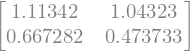

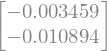

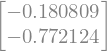

In [20]:
for x in model.get_weights():
    display(Matrix(np.round(x,6)))

And now with our numpy/sympy version:

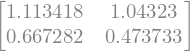

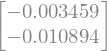

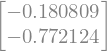

In [21]:
# Apply weight updates
new_weights = [input_to_hidden + input_to_hidden_updates,
               hidden_bias + hidden_bias_updates,
               hidden_to_output + hidden_to_output_updates,
               output_bias + output_bias_updates]
for x in new_weights:
    display(Matrix(np.round(x,6)))

Note that I have needed to round the results to about 6 digits of precision to observe agreement. There are some slight numerical difference between the way that keras calculates certain quantities compared to numpy/sympy, but we can clearly see how keras makes model construction and training very simple. Even the numpy/sympy approach is much easier than lower level languages like C/C++/Fortran.

So, there you have it: error backpropagation from "scratch".

## Visualizing/Understanding Network Behavior

Before we get to fully training up the model, let's see if we can set up a visualization tool that will help us understand how the network is behaving. Simple examples can be very insightful since they can often be investigated more thoroughly than a more complex example, given that the simple example contains the interesting elements that we are looking for.

First, we will create a **meshgrid** of data points (i.e. feature vectors) which _cover_ the space of input vectors for the XOR task thoroughly. This isn't easy to do in a high-dimensional space, since the space requirements grow exponentially with the dimensionality of the input vectors. However, just two dimensions can be visualized and covered with a reasonable number of points.

The `linspace()` function will be used again to create a set of points, now ranging from -2 to 2 (20 distinct values in that range). Next, we use the `meshgrid()` function to create all possible combinations of those values (20x20=400 points!). The `xgrid` and `ygrid` data structures are each 20x20 matrices, where each point we want to visualize will be a combination of corresponding values from each matrix: $\left[ xgrid_{ij}, ygrid_{ij} \right]$ for all i,j. However, this means we need to flatten each of those matrices and combine their corresponding elements into these 2-dimensional vectors. We use a combination of `ravel()` (to perform the flattening) and `vstack()` (to perform the concatenation). The result will actually be the transpose of the final data matrix that we want, so don't forget the `T` at the end.

Now, we will plot all of those data points in green just to show the grid we have made. However, we will also then plot the XOR input vectors (X) colored by their corresponding class labels (0,1), and also a little larger to make them stand out. In this case, __red is zero, and blue is one__.

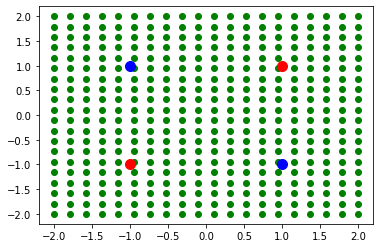

In [22]:
# Sample plot of classification space
xpoints = np.linspace(-2,2,20)
ypoints = np.linspace(-2,2,20)
xgrid, ygrid = np.meshgrid(xpoints,ypoints)
positions = np.vstack([xgrid.ravel(),ygrid.ravel()]).T

# Green grid points where we will evaluate the network
# outputs.
plt.plot(positions[:,0],positions[:,1],'go')

# Color the zero-expected outputs red
plt.plot(X[[0,3],0],X[[0,3],1],'ro',markersize=10)
# Color the one-expected outputs blue
plt.plot(X[[1,2],0],X[[1,2],1],'bo',markersize=10)
plt.show()

Now, let's use this data to visualize how the XOR network behaves. That is, we can use the visualization to examine the current decision boundary that the network is using. You may ask, how could there be a boundary before training? Well, we initialize the weights in the network randomly, so while probably not very useful, the boundary is already there.

For this operation, we need to use the `predict_classes()` function from the model. This is similar to "testing" the neural network, but instead of calculating a loss or accuracy value, we prefer to just see what class label (`predictions`) was assigned to each input vector. We provide all of the grid `positions` calculated above and each one gets assigned to a class of 0 or 1. We can then separate the data into two sets: those input vectors classified as a zero and those input vectors classified as a one. We perform a slice using a boolean operator this time, and then select the matching rows from the `positions` matrix and create two non-overlapping matrices of vectors: `zeros` and `ones`.

Now, rather than coloring them green, we can color them according to the class label that the network _predicted_ for each vector in the grid. By making the XOR vectors a little larger on the plot, it's easy to separate them from the others in the grid as well.

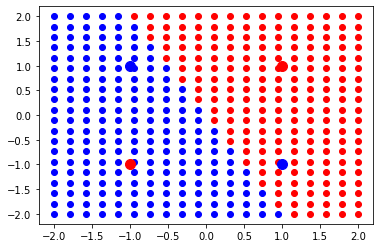

In [23]:
# Let's color those points by the classification labels...
predictions = np.int32(np.round(model.predict(positions)[:,0]))
zeros = positions[predictions==0,:]
ones = positions[predictions==1,:]

# Color predictions by class
plt.plot(zeros[:,0],zeros[:,1],'ro')
plt.plot(ones[:,0],ones[:,1],'bo')

# Color the zero-expected outputs red
plt.plot(X[[0,3],0],X[[0,3],1],'ro',markersize=10)
# Color the one-expected outputs blue
plt.plot(X[[1,2],0],X[[1,2],1],'bo',markersize=10)

plt.show()

The grid point covering let's us visualize the decision boundary determined by the network, since the grid points will change from red to blue or vice-versa.

As you can see, the network starts with a suboptimal decision boundary for the task (as expected). Now, let's see if the network can learn to solve the problem.

In [24]:
# Train it!
history = model.fit(X, Y,
    batch_size=1,
    epochs=1000,
    verbose=0)

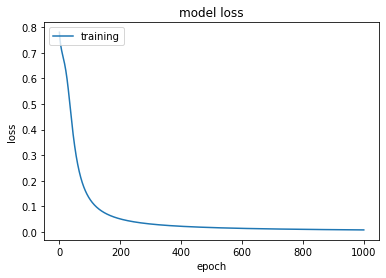

In [25]:
# summarize history for loss  
plt.plot(history.history['loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['training'], loc='upper left')  
plt.show()

In [26]:
score = model.evaluate(X,Y,verbose=1)
print("Accuracy:",score[1]*100.0, "%")

1/1 [==============================] - 0s 2ms/step - loss: 0.0081 - binary_accuracy: 1.0000
Accuracy: 100.0 %


Note that the evaluation score here is *error* or *loss* which is zero when things are going well, so it looks like it might have been successful.

Now that we have trained the network for a little while, let's see what the network has learned. We can perform the same steps as above, but using predictions from the network _after training_.

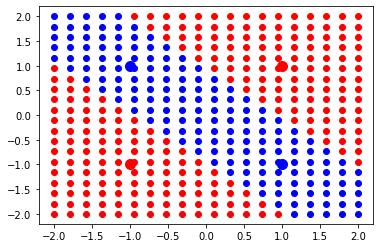

In [27]:
# Let's color those points by the classification labels...
predictions = np.int32(np.round(model.predict(positions)[:,0]))
zeros = positions[predictions==0,:]
ones = positions[predictions==1,:]

# Color predictions by class
plt.plot(zeros[:,0],zeros[:,1],'ro')
plt.plot(ones[:,0],ones[:,1],'bo')

# Color the zero-expected outputs red
plt.plot(X[[0,3],0],X[[0,3],1],'ro',markersize=10)
# Color the one-expected outputs blue
plt.plot(X[[1,2],0],X[[1,2],1],'bo',markersize=10)

plt.show()

So, the tanh hidden units were able to provide good boundaries that the output unit could use to decipher the class structure in the data, even in a non-linear manner. If you reinitialized the network weights, you might find that the learned boundary is not always the same. Some problems can be solved in different ways, and therefore different networks may utilize different ways of partitioning the feature space to solve them even if being trained on _the same data_.

## Enter the ReLU

Let's try to see what happens if we utilize our new activation function, ReLU, which we now know has some nice properties for solving complex problems using deeper networks.

The same approach will be used here as was used above, so we will only replace the tanh function with the ReLU activation function. Remember that it has been suggested in the deep learning literature, that initializing the _bias weights_ on ReLU units to small positive values. We will use that technique here to demonstrate how this might work, but it _may not always be a good idea_. Keep that in mind during the exercises below...

In [28]:
# Multi-layer net with ReLU hidden layer
model = keras.models.Sequential()

# Here we make the hidden layer (size 2) with a ReL
# activation function, but also initialize the bias
# weights in the network to a constant 0.1
model.add(keras.layers.Dense(2,input_dim=2,activation='relu',
                             bias_initializer=keras.initializers.Constant(0.1)))

# Output layer (size 1), sigmoid activation function
model.add(keras.layers.Dense(1,activation='sigmoid'))

# Compile as above (default learning rate and other
# hyperparameters for the Adam optimizer).
model.compile(loss=keras.losses.BinaryCrossentropy(),
              optimizer=keras.optimizers.Nadam(),
              metrics=keras.metrics.BinaryAccuracy())

# Display the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 2)                 6         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 3         
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________


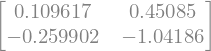

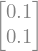

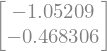

In [29]:
# Note the initializer for the hidden unit bias weights
for i in model.get_weights():
    display(Matrix(i))

Let's see how this net stacks up to the tanh net using our visualization method above. Remember, we are still _pre-training_ here for this network.

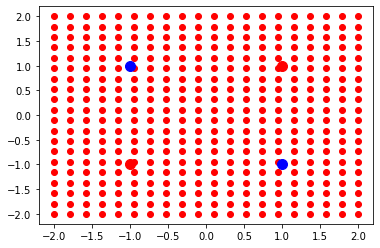

In [30]:
# Let's color those points by the classification labels...
predictions = np.int32(np.round(model(positions)[:,0]))
zeros = positions[predictions==0,:]
ones = positions[predictions==1,:]

# Color predictions by class
plt.plot(zeros[:,0],zeros[:,1],'ro')
plt.plot(ones[:,0],ones[:,1],'bo')

# Color the zero-expected outputs red
plt.plot(X[[0,3],0],X[[0,3],1],'ro',markersize=10)
# Color the one-expected outputs blue
plt.plot(X[[1,2],0],X[[1,2],1],'bo',markersize=10)

plt.show()

Sometimes, we will see a boundary, but with certain initial sets of weights we may not. Let's see if some training pushes that boundary into (or closer to) the visible space of input vectors...

In [31]:
# Train it!
history = model.fit(X, Y,
    batch_size=1,
    epochs=1000,
    verbose=0)

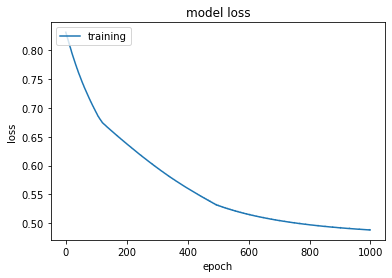

In [32]:
# summarize history for loss  
plt.plot(history.history['loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['training'], loc='upper left')  
plt.show()

In [33]:
# final accuracy
score = model.evaluate(X,Y)
print("Accuracy:",score[1]*100.0, "%")

1/1 [==============================] - 0s 3ms/step - loss: 0.4880 - binary_accuracy: 0.7500
Accuracy: 75.0 %


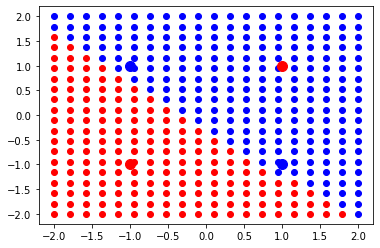

In [34]:
# Let's color those points by the classification labels...
predictions = np.int32(np.round(model(positions)[:,0]))
zeros = positions[predictions==0,:]
ones = positions[predictions==1,:]

# Color predictions by class
plt.plot(zeros[:,0],zeros[:,1],'ro')
plt.plot(ones[:,0],ones[:,1],'bo')

# Color the zero-expected outputs red
plt.plot(X[[0,3],0],X[[0,3],1],'ro',markersize=10)
# Color the one-expected outputs blue
plt.plot(X[[1,2],0],X[[1,2],1],'bo',markersize=10)

plt.show()

Well, that's not very promising is it? Is ReLU that useful after-all? What might be the problem here?

We've seen how to train a multilayer network using both tanh and ReLU at least, even if the results are not very spectacular. However, you should have some intuition about how this problem might be rectified using some hints on the lecture slides and what we have talked about in class...

## Classifying MNIST

The MNIST data set consists of 60,000 images of handwritten digits for training and 10,000 images of handwritten digits for testing. We looked at this data in our last homework assignment some, but now we will try to train up a network for classifying these images.

First, let's load the data and prepare it for presentation to a network.

In [35]:
from tensorflow.keras.datasets import mnist

# Digits are zero through nine, so 10 classes
num_classes = 10

# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], img_rows * img_cols)
x_test = x_test.reshape(x_test.shape[0], img_rows * img_cols)

# Data normalization (0-255 is encoded as 0-1 instead)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.0
x_test /= 255.0

# Convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Shape information
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (60000, 784)
y_train shape: (60000, 10)
60000 train samples
10000 test samples


You can see that we have flattened each image (28x28 pixels) into a 728-element vector using the `reshape()` function. The intensity values in the original data are in the range 0-255, but we divide them all by 255 in order to scale the intensity between 0 and 1. This just keeps us from starting at extreme values in the weight space (where tanh and sigmoid get stuck easily). Finally, we convert the integer class labels (originally just 0,1,2,...,9) into the categorical, one-hot representation that we need for `categorical cross-entropy`.

OK, so we need to train a network to recognize these digits. We will fully utilize the training/validation data alone when tuning parameters, and run a final accuracy check on the _test_ data which was _never seen_ during the training process. Let's see what a __single-layer__ network can do to start with...

In [36]:
model = keras.models.Sequential()

# Linear
model.add(keras.layers.Dense(num_classes, activation='softmax',input_shape=[x_train.shape[1]]))
model.compile(loss=keras.losses.CategoricalCrossentropy(),
              optimizer=keras.optimizers.Nadam(),
              metrics=keras.metrics.CategoricalAccuracy())
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


There is quite a bit of data to get through here: 180,000 image presentations to the network across 30 epochs, so be patient while it's training up. In truth, keras will make rather quick work of it by utilizing the parallel resources on biosim or your own machine quite effectively. We will learn more about that process later in the semester.

In [37]:
%%time
# Train it!
history = model.fit(x_train, y_train,
          batch_size=128,
          epochs=30,
          verbose=0,
          validation_split=0.2)
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1]*100.0, "%")

Test loss: 0.2640944719314575
Test accuracy: 92.83000230789185 %
CPU times: user 1min 27s, sys: 24.7 s, total: 1min 52s
Wall time: 38.7 s


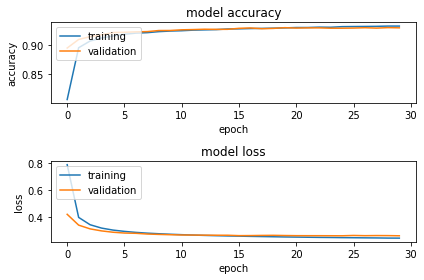

In [38]:
plt.figure()  
   
# summarize history for accuracy  
   
plt.subplot(211)  
plt.plot(history.history['categorical_accuracy'])  
plt.plot(history.history['val_categorical_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['training', 'validation'], loc='upper left')  
   
# summarize history for loss  
   
plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['training', 'validation'], loc='upper left')

plt.tight_layout()
plt.show()  

Excellent! Let's take one more look at that accuracy...

In [39]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1]*100.0, "%")

Test loss: 0.2640944719314575
Test accuracy: 92.83000230789185 %


Just a single layer network is capable of performing above 92% accuracy on examples that it has never even seen during training. So, the gauntlet has been thown: can a deeper net do better? We'll find out...